In [22]:
import os
print(os.listdir('../data/raw/cbioportal'))

['cna.txt', 'clinical.tsv', 'mrna_z.txt', 'mutations.txt']


In [23]:
import pandas as pd, os

BASE = '../data/raw/cbioportal'
clin = pd.read_csv(os.path.join(BASE, 'clinical.tsv'), sep='\t')

hpv_col   = 'Hpv status p16'
stage_col = 'American Joint Committee on Cancer Tumor Stage Code'

mask = (
    clin[hpv_col].eq('Negative') &
    clin[stage_col].str.match(r'^(T3|T4)', na=False)
)
subset_ids = clin.loc[mask, 'Sample ID'].tolist()
print(len(subset_ids))

43


In [24]:
print(clin.columns[clin.columns.str.contains('Clinical Group Stage')])
print(clin['Neoplasm American Joint Committee on Cancer Clinical Group Stage'].value_counts(dropna=False))

Index(['Neoplasm American Joint Committee on Cancer Clinical Group Stage'], dtype='object')
Neoplasm American Joint Committee on Cancer Clinical Group Stage
Stage IVA    271
Stage III    107
Stage II      99
Stage I       21
NaN           14
Stage IVB     11
Stage IVC      7
Name: count, dtype: int64


In [25]:
import pandas as pd
from pathlib import Path

BASE = Path('../data/raw/cbioportal')
genes = ['B2M','NLRC5','TAP1','IRF1','STAT1','CXCL9','CXCL10','PSMB9','HLA-A','HLA-B']

expr    = (pd.read_csv(BASE/'mrna_z.txt', sep='\t')
             .rename(columns={'SAMPLE_ID':'sample'})
             .set_index('sample')
             .loc[subset_ids, genes]
             .T.astype(float))
cna     = (pd.read_csv(BASE/'cna.txt', sep='\t')
             .rename(columns={'SAMPLE_ID':'sample'})
             .set_index('sample')
             .loc[subset_ids, genes]
             .T.astype(float))
mut_raw = (pd.read_csv(BASE/'mutations.txt', sep='\t', low_memory=False)
             .rename(columns={'SAMPLE_ID':'sample'})
             .set_index('sample')
             .loc[subset_ids, genes])

low_expr = (expr <= -1.0).astype(int)       # ← correct: z ≤ –1.0 (Papers correspond to -1 to -1.5
cna_del  = (cna  <= -1.5).astype(int)       # ← deep deletions at ≤ –1.5
mut      = (mut_raw
             .replace({'':0,'0':0,'0.0':0})
             .apply(pd.to_numeric, errors='coerce')
             .fillna(0)
             .ne(0)
             .astype(int))

vis = low_expr.copy()
vis[cna_del == 1] = 2
vis[mut     == 1] = 3

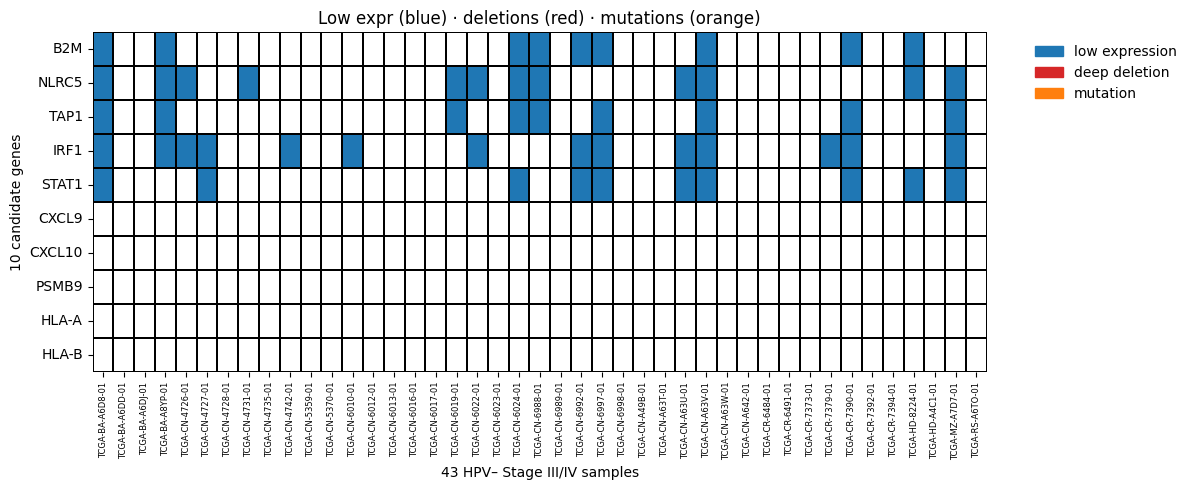

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

cmap = ListedColormap(['white','#1f77b4','#d62728','#ff7f0e'])

plt.figure(figsize=(len(subset_ids)*0.28, 5))
ax = sns.heatmap(vis, cmap=cmap, vmin=0, vmax=3,
                 cbar=False, linewidths=.3, linecolor='black')
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0)
plt.xlabel(f'{len(subset_ids)} HPV– Stage III/IV samples')
plt.ylabel('10 candidate genes')
plt.title('Low expr (blue) · deletions (red) · mutations (orange)')

handles = [
    mpatches.Patch(color=cmap(i), label=l)
    for i, l in zip([1,2,3], ['low expression','deep deletion','mutation'])
]
ax.legend(handles=handles, bbox_to_anchor=(1.04,1), loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig('../docs/heatmap_epirevive_HPVneg_stage3-4.png',
            dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# how many deletion & mutation events did we actually flag?
print("total deep deletions:",   cna_del.sum().sum())
print("total mutation calls:",   mut.sum().sum())

# per-gene breakdown
print("\n# deep deletions per gene:")
print(cna_del.sum(axis=1))
print("\n# mutations per gene:")
print(mut.sum(axis=1))

total deep deletions: 0
total mutation calls: 0

# deep deletions per gene:
B2M       0
NLRC5     0
TAP1      0
IRF1      0
STAT1     0
CXCL9     0
CXCL10    0
PSMB9     0
HLA-A     0
HLA-B     0
dtype: int64

# mutations per gene:
sample
TCGA-BA-A6D8-01    0
TCGA-BA-A6DD-01    0
TCGA-BA-A6DJ-01    0
TCGA-BA-A8YP-01    0
TCGA-CN-4726-01    0
TCGA-CN-4727-01    0
TCGA-CN-4728-01    0
TCGA-CN-4731-01    0
TCGA-CN-4735-01    0
TCGA-CN-4742-01    0
TCGA-CN-5359-01    0
TCGA-CN-5370-01    0
TCGA-CN-6010-01    0
TCGA-CN-6012-01    0
TCGA-CN-6013-01    0
TCGA-CN-6016-01    0
TCGA-CN-6017-01    0
TCGA-CN-6019-01    0
TCGA-CN-6022-01    0
TCGA-CN-6023-01    0
TCGA-CN-6024-01    0
TCGA-CN-6988-01    0
TCGA-CN-6989-01    0
TCGA-CN-6992-01    0
TCGA-CN-6997-01    0
TCGA-CN-6998-01    0
TCGA-CN-A49B-01    0
TCGA-CN-A63T-01    0
TCGA-CN-A63U-01    0
TCGA-CN-A63V-01    0
TCGA-CN-A63W-01    0
TCGA-CN-A642-01    0
TCGA-CR-6484-01    0
TCGA-CR-6491-01    0
TCGA-CR-7373-01    0
TCGA-CR-7379-01    0
TCGA-

In [28]:
# total low‐expression events
print("total low‐expr flags:", low_expr.sum().sum())

# per-gene breakdown
print("\n# low‐expr flags per gene:")
print(low_expr.sum(axis=1))

# (optional) per-sample breakdown
print("\n# low‐expr flags per sample:")
print(low_expr.sum(axis=0))

total low‐expr flags: 54

# low‐expr flags per gene:
B2M        9
NLRC5     12
TAP1       9
IRF1      14
STAT1     10
CXCL9      0
CXCL10     0
PSMB9      0
HLA-A      0
HLA-B      0
dtype: int64

# low‐expr flags per sample:
sample
TCGA-BA-A6D8-01    5
TCGA-BA-A6DD-01    0
TCGA-BA-A6DJ-01    0
TCGA-BA-A8YP-01    4
TCGA-CN-4726-01    2
TCGA-CN-4727-01    2
TCGA-CN-4728-01    0
TCGA-CN-4731-01    1
TCGA-CN-4735-01    0
TCGA-CN-4742-01    1
TCGA-CN-5359-01    0
TCGA-CN-5370-01    0
TCGA-CN-6010-01    1
TCGA-CN-6012-01    0
TCGA-CN-6013-01    0
TCGA-CN-6016-01    0
TCGA-CN-6017-01    0
TCGA-CN-6019-01    2
TCGA-CN-6022-01    2
TCGA-CN-6023-01    0
TCGA-CN-6024-01    4
TCGA-CN-6988-01    3
TCGA-CN-6989-01    0
TCGA-CN-6992-01    3
TCGA-CN-6997-01    4
TCGA-CN-6998-01    0
TCGA-CN-A49B-01    0
TCGA-CN-A63T-01    0
TCGA-CN-A63U-01    3
TCGA-CN-A63V-01    5
TCGA-CN-A63W-01    0
TCGA-CN-A642-01    0
TCGA-CR-6484-01    0
TCGA-CR-6491-01    0
TCGA-CR-7373-01    0
TCGA-CR-7379-01    1
TCGA-CR-739